# Nettoyage des données

## Set up

### Mise en place de l'environnement

In [1295]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import missingno as msno 
import re
from sklearn.linear_model import LinearRegression


import sys
sys.path.insert(0, "/home/apprenant/PycharmProjects/open-food-facts")

In [1296]:
# On veut pouvoir voir toutes les colonnes et toutes les lignes des dataframes
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

### Import des données

In [1297]:
df = pd.read_csv("/home/apprenant/Downloads/openfoodfacts.tsv", sep='\t', low_memory=False)

## Suppression des colonnes inutilisées

On va garder uniquement les 29 colonnes qu'on va utiliser comme défini dans la partie analyse.

In [1298]:
df = df[['product_name', 'brands', 'countries_en', 'pnns_groups_1',
         'ingredients_text', 'allergens', 'traces', 'additives_en',
         'ingredients_from_palm_oil_n','nutrition_grade_fr', 'energy_100g',
         'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'salt_100g', 'sodium_100g',
         'fat_100g', 'carbohydrates_100g',
         'proteins_100g', 'nutrition-score-fr_100g', 'fruits-vegetables-nuts_100g',
         'vitamin-d_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'image_url',
         'generic_name', 'pnns_groups_2', 'fruits-vegetables-nuts-estimate_100g']]
print(df.shape)

(356027, 29)


## Selection des produits disponibles en France

On ne va travailler que sur les produits disponibles en France. On commence par normaliser l'ensemble des cellules contenant le mot "France" pour pouvoir les récupérer ensuite. 

In [1299]:
# Permet de convertir toutes les chaines de caractères contenant France en France.
df["countries_en"] = df["countries_en"].apply(
    lambda x: "France" if re.match(r".*(France).*", str(x), re.IGNORECASE) else x
)
df = df[df.countries_en == 'France']
print(df.shape)

(129320, 29)


On constate qu'on a conservé 129320 lignes sur les 356027 initiales. 

## product_name

On va remplacer les valeurs manquantes de product_name par celles contenues dans generic_name quand c'est possible. Ensuite on supprimera les lignes où product_name est vide qui sont donc inutilisables.

In [1300]:
temp = (df["product_name"].isnull().sum())

In [1301]:
# On remplace les valeurs manquantes de product_name par generic_name 
df.loc[df["generic_name"].notna() & df["product_name"].isna(), "product_name"] = df["generic_name"]

In [1302]:
# Calcul du nombre de valeurs modifiées
temp - (df["product_name"].isnull().sum())

32

In [1303]:
# On supprime les lignes où product_name n'est pas renseigné
df.dropna(subset=["product_name"], inplace=True)
print(df.shape)

(123065, 29)


## Suppression des doublons

On va supprimer les lignes en doubles pour n'en garder qu'une seule. 

In [1304]:
df.drop_duplicates(inplace=True)
print(df.shape)

(122505, 29)


## pnns_groups_1

On va remplacer les valeurs manquantes de pnns_groups_1 par celles contenues dans pnns_groups_2 pour commencer.

In [1305]:
temp=(df["pnns_groups_1"].isnull().sum())

In [1306]:
df.loc[df["pnns_groups_2"].notna() & df["pnns_groups_1"].isna(), "pnns_groups_1"] = df["pnns_groups_2"]

In [1307]:
# Calcul du nombre de valeurs modifiées
temp-df["pnns_groups_1"].isnull().sum()

2623

## fruits-vegetables-nuts_100g

On va remplacer les valeurs manquantes de fruits-vegetables-nuts_100g par celles contenues dans fruits-vegetables-nuts-estimate_100g.

In [1308]:
temp = (df["fruits-vegetables-nuts_100g"].isnull().sum())

In [1309]:
df.loc[df["fruits-vegetables-nuts-estimate_100g"].notna() & df["fruits-vegetables-nuts_100g"].isna(), "fruits-vegetables-nuts_100g"] = df["fruits-vegetables-nuts-estimate_100g"]

In [1310]:
# Calcul du nombre de valeurs modifiées
temp - df["fruits-vegetables-nuts_100g"].isnull().sum()

379

## Gestion des valeurs nutritionnelles numériques

### Suppression des lignes inexploitables

On va supprimer les lignes dont il manque le nutriscore et les éléments pour le calculer. 

In [1311]:
# On supprime les lignes où le nutriscore et les valeurs nutritionnelles ne sont pas renseignées
df.dropna(subset=['nutrition-score-fr_100g','saturated-fat_100g', 'sugars_100g', 'fiber_100g',
          'salt_100g', 'fat_100g',
          'carbohydrates_100g', 'proteins_100g',
          'fruits-vegetables-nuts_100g'], how='all', inplace=True)
print(df.shape)

(97042, 29)


### Remplacement des valeurs nutritionnelles manquantes

On va remplacer les valeurs nutritionnelles manquantes par 0.

In [1312]:
# On liste les colonnes dont on veut remplacer les valeurs manquantes par 0
cols = ['ingredients_from_palm_oil_n',
         'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'salt_100g',
         'fat_100g', 'carbohydrates_100g', 'sodium_100g'
         'proteins_100g', 'fruits-vegetables-nuts_100g',
         'vitamin-d_100g', 'vitamin-c_100g', 'calcium_100g',
        'iron_100g', 'proteins_100g']
# On fait une liste remplie de 0 de même longueur que le nombre de colonnes à modifier
vals = np.zeros(len(cols))
# On combine ces 2 listes dans un dictionnaire pour pouvoir l'entrer en paramètre de fillna
dico = dict(zip(cols, vals))
# On remplace les valeurs manquantes par 0
df.fillna(dico, inplace=True)

### Suppression des valeurs impossibles

On va supprimer les lignes dont les valeurs sont négatives ou au dessus de 100 grammes pour chacune des valeurs nutritionnelles utilisées. Pour commencer, on va fixer les valeurs limites. Pour les valeurs nutritionnelles, elles devront être comprises entre 0 et 100 grammes. Pour le nutriscore, il est toujours compris entre -15 et 40. Regardons la répartition de l'énergie. 

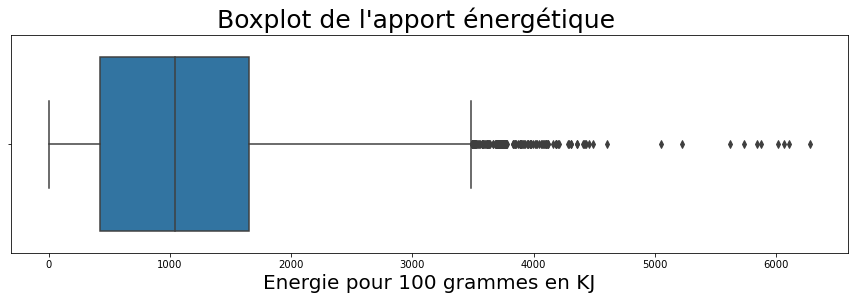

In [1313]:
ax = sns.boxplot(x=df['energy_100g'])
fig = plt.gcf()
# Modification de la taille
fig.set_size_inches(15,4)
# Ajout du titre et de la légende
fig.suptitle("Boxplot de l'apport énergétique", fontsize=25)
plt.xlabel("Energie pour 100 grammes en KJ", fontsize=20);

In [1314]:
# Echantillon des produits dont l'énergie est supérieure à 3700 kjoules
print(df.loc[df['energy_100g'] > 3700][["product_name", "energy_100g"]].sample(10))

                                             product_name  energy_100g
276400                                     Capital Cardio       3766.0
201354                    Huile vierge de sesame ERIC BUR       3766.0
338218                          Oli Carbonell Verge Extra       3766.0
228813  Huile d'Olive Vierge Extra, la verte Puissante...       3766.0
268129                               Huile vierge de coco       3766.0
206759                                 Huile de tournesol       3770.0
250071                                      Huile De Noix       3766.0
228823                                        Oméga 3 & 6       3766.0
250056                                Huile vierge de Lin       3766.0
254412  Château Virant Famille Cheylan Aix-en-Provence...       3768.0


Nous voyons qu'en fixant la limite à 3700, on élimine majoritairement des huiles qui sont à un apport énergétique cohérent. Il faudrait donc encore rehausser la limite.

In [1315]:
# Echantillon des produits dont l'énergie est supérieure à 3800 kjoules
print(df.loc[df['energy_100g'] > 3800][["product_name", "energy_100g"]].sample(5))

                              product_name  energy_100g
265936  Filets de Maquereaux à l'Escabèche       3887.0
181742                  Lot De 4 Baguettes       4184.0
305256           Vinaigrette miel moutarde       6017.0
351556                        Huile de riz       3853.0
265786     Sardines A L'huile De Tournesol       4485.0


On va poser 3800 KJoules comme étant la limite maximale pour l'énergie, en effet, on ne retrouve plus que des valeurs aberrantes pour les produits en question. 

In [1316]:
# On veut que nos valeurs nutritionnelles pour 100g soient comprises entre 0 et 100
minValNut = 0
maxValNut = 100
# Notre nutriscore doit être compris entre -15 et 40 pour être valide
minNutSco = -15
maxNutSco = 40
# La valeur énergétique pour 100g doit être comprises entre 0 et 3800 kJ
minNrj = 0
maxNrj = 3800

On peut commencer par supprimer les valeurs aberrantes individuellement

In [1317]:
# Ensemble des valeurs nutritionnelles
new_df = df[['saturated-fat_100g', 'sugars_100g', 'fiber_100g',
              'salt_100g', 'fat_100g',
              'carbohydrates_100g', 'proteins_100g',
              'fruits-vegetables-nuts_100g', 'vitamin-d_100g', 'vitamin-c_100g',
              'calcium_100g', 'iron_100g']]

# Mask regroupant l'ensemble des conditions 
mask = new_df.le(100).all(axis=1) & new_df.ge(0).all(axis=1) & ((df['energy_100g'].ge(minNrj) & df['energy_100g'].le(maxNrj)) | df['energy_100g'].isna() ) & df['nutrition-score-fr_100g'].ge(minNutSco) & df['nutrition-score-fr_100g'].le(maxNutSco)  
df = df[mask]
print(df.shape)

(92874, 29)


On va maintenant vérifier que la somme des graisses, glucides, protéines et sel, qui sont des composants indépendants, est bien inférieure à 100 grammes pour 100 grammes de produit. On ne met pas de valeur minimale, ce serait redondant avec les limites individuelles fixées précédemment. L'eau, par exemple, aura une somme proche de valeurs nutritionnelles proches de 0.

In [1318]:
df = df[df[['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g']].sum(axis=1) <= 100]
df.shape

(92624, 29)

## Détermination des paires de variables les plus corrélées

### Visualisation des corrélations

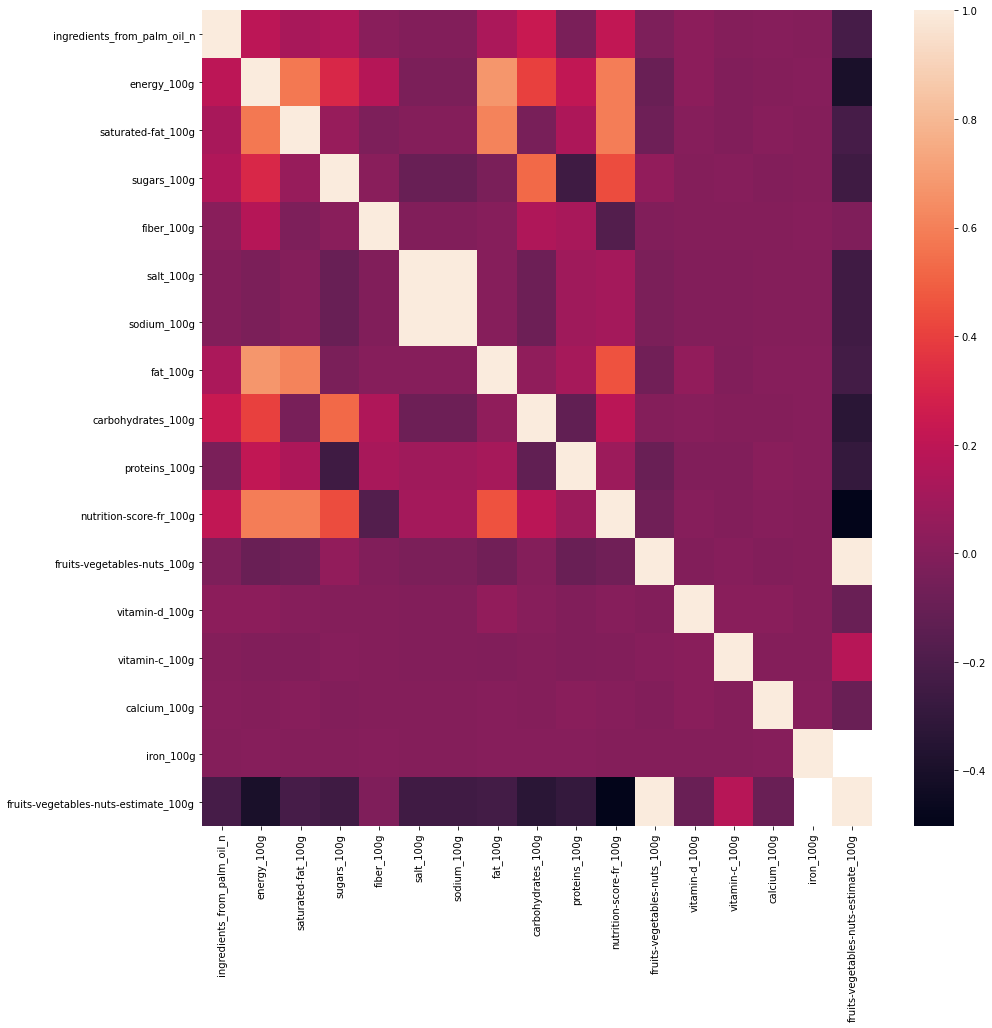

In [1319]:
ax=sns.heatmap(df.corr(), xticklabels=True, yticklabels=True)
fig = plt.gcf()
# Modifie la taille du graphique
fig.set_size_inches(15,15)

Sur cette heatmap, on peut voir les niveaux de corrélation entre les différentes colonnes de notre tableau.
On voit la forte corrélation entre le sel et le sodium qui est logique, le rapport entre les 2 étant de 2.54. 
On voit aussi qu'il y a une corrélation plutôt marquée entre l'énergie et la graisse, ce qui vient du fait que c'est l'élément qui apporte le plus d'énergie. Il y a également corrélation linéaire entre la graisse saturée et la graisse, la graisse saturée étant une partie de la graisse, ces 2 valeurs sont donc liées.
De même, nutrition-score-fr_100g est corrélé avec l'energie et les graisses saturées, ce qui est pertinent vu la façon d'obtenir le nutriscore. 

## Représentation des pairplots

On va montrer le pairplot sur un nombre de colonnes réduit pour avoir les plus pertinentes et avoir un graphe tout de même lisible.

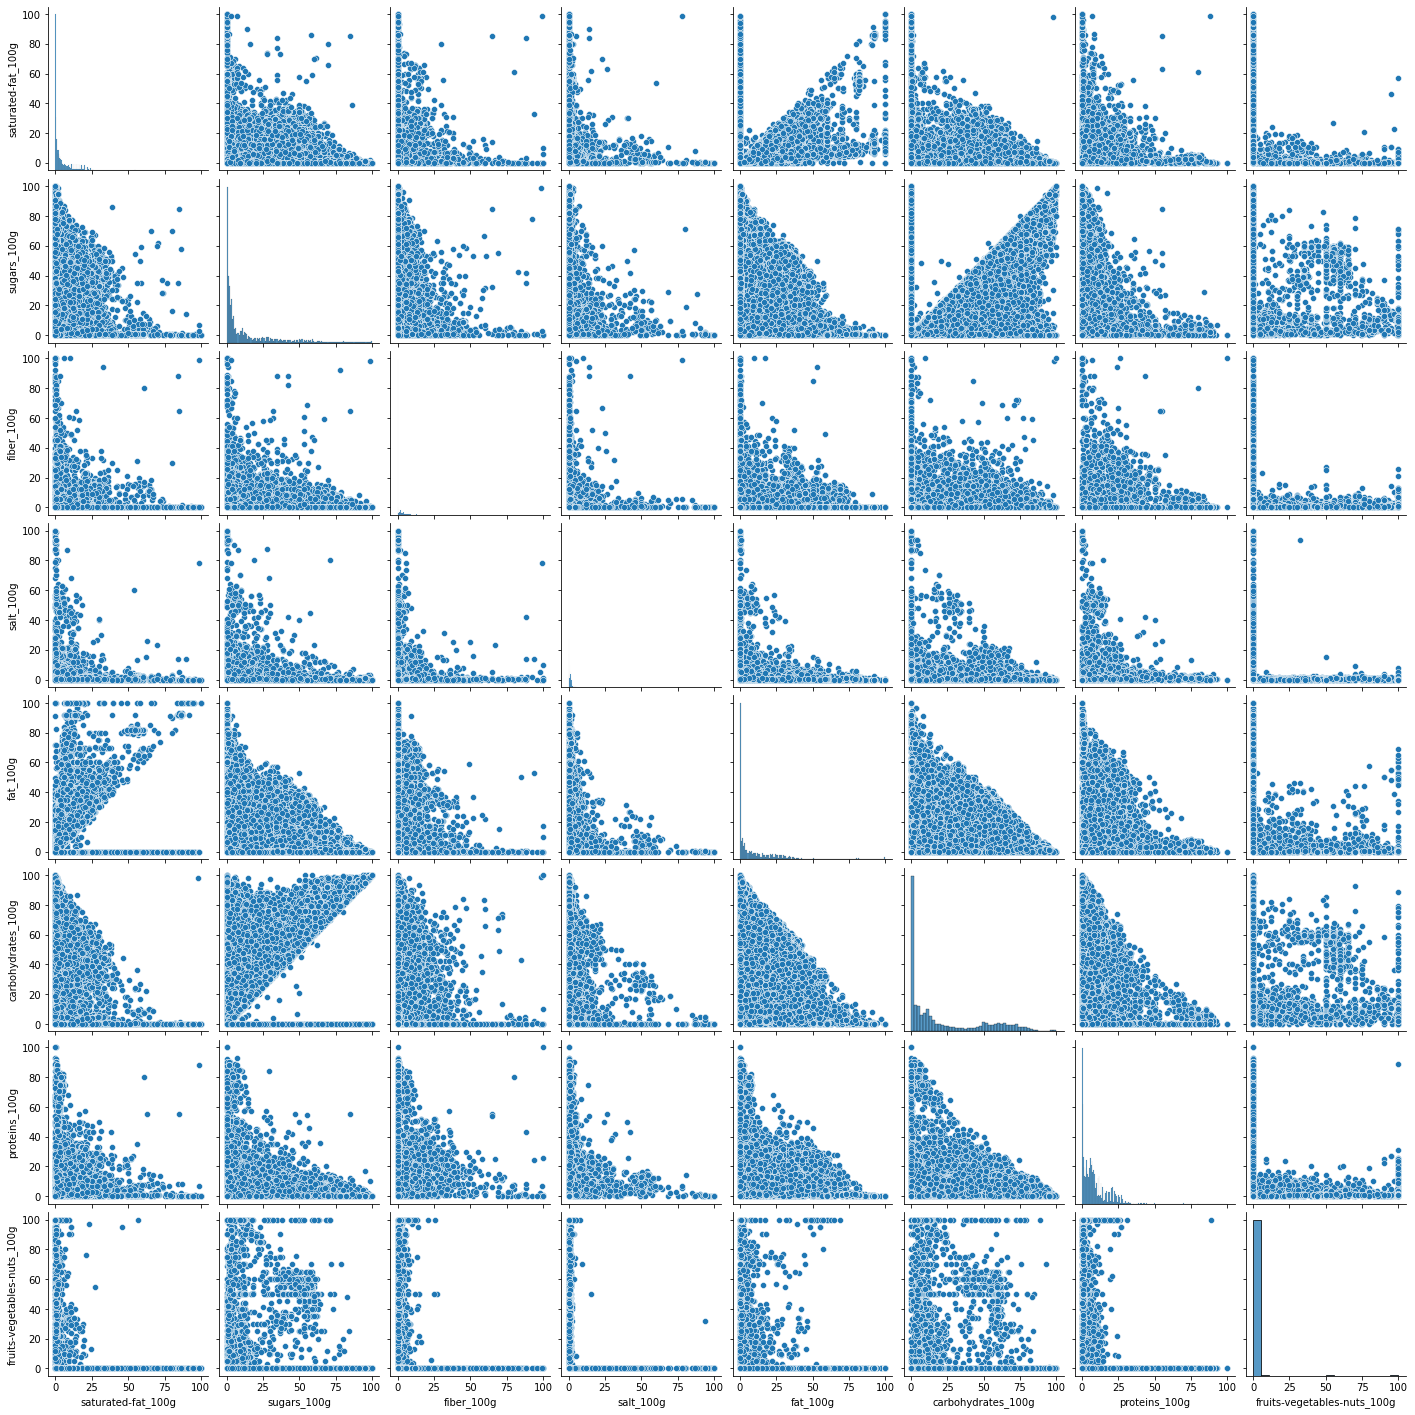

In [1320]:
sns.pairplot(df[['saturated-fat_100g', 'sugars_100g', 'fiber_100g',
              'salt_100g', 'fat_100g',
              'carbohydrates_100g', 'proteins_100g',
              'fruits-vegetables-nuts_100g']]);

On retrouve la même conclusion que précédemment. On voit bien la diagonale qui implique que le sucre a une valeur moins élevé que les glucides et que la graisse saturée a une valeur moins élevée que la graisse. C'est vrai pour la majorité des valeurs, il faudra traiter celles pour lesquelles ce n'est pas le cas. 

### Détermination des paires de variables corrélées

In [1321]:
# Calcul des coefficients de corrélations
dfcorr = df.corr()
tabl = pd.DataFrame(columns = ['valeur', 'paire', 'coeff_correl'])
# Parcours du tableau des coefficients
for col in dfcorr:
    # On extrait le plus grand coefficient et la paire pour laquelle ce coeff est atteint
    a = dfcorr[col].drop(labels=[col]).abs()
    tabl = tabl.append({'valeur':col, 'paire':a.idxmax(), 'coeff_correl':round(a.max(),2)}, ignore_index=True)
print(tabl.sort_values(['coeff_correl'], ascending=False))

                                  valeur  \
16  fruits-vegetables-nuts-estimate_100g   
11           fruits-vegetables-nuts_100g   
5                              salt_100g   
6                            sodium_100g   
1                            energy_100g   
7                               fat_100g   
2                     saturated-fat_100g   
10               nutrition-score-fr_100g   
8                     carbohydrates_100g   
3                            sugars_100g   
9                          proteins_100g   
0            ingredients_from_palm_oil_n   
4                             fiber_100g   
13                        vitamin-c_100g   
12                        vitamin-d_100g   
14                          calcium_100g   
15                             iron_100g   

                                   paire  coeff_correl  
16           fruits-vegetables-nuts_100g          1.00  
11  fruits-vegetables-nuts-estimate_100g          1.00  
5                            sodium_

### Visualisation graphique des paires de variables

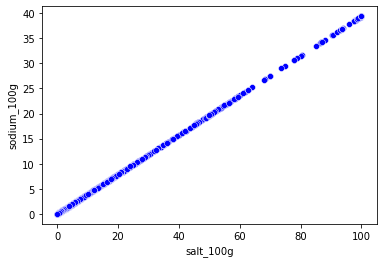

In [1322]:
ax = sns.scatterplot(x='salt_100g', y='sodium_100g', data=df, color="blue")

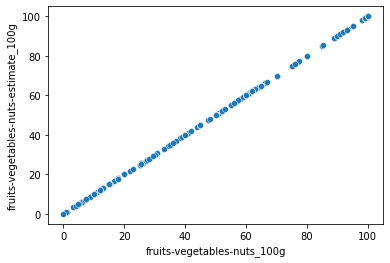

In [1323]:
ax = sns.scatterplot(x='fruits-vegetables-nuts_100g', y='fruits-vegetables-nuts-estimate_100g', data=df)

Pour sel et sodium et pour les pourcentages de fruits et légumes, on a un coefficient de corrélation de 1, on retrouve donc bien des droites. 

### Traitement des valeurs de graisse

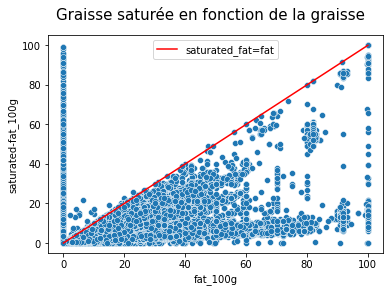

In [1324]:
ax = sns.scatterplot(y='saturated-fat_100g', x='fat_100g', data=df)
x = np.linspace(0,100,3)
y = x
plt.plot(x, y, '-r', label='saturated_fat=fat')
fig = plt.gcf()
# Ajout du titre
fig.suptitle("Graisse saturée en fonction de la graisse", fontsize=15);
plt.legend();

On observe qu'il y a des produits pour lesquels il y a plus de graisses saturées que de graisses, ce qui est impossible. Il faut que toutes les valeurs soient en dessous de la droite. Il faut donc les traiter. 

In [1325]:
# On détermine la moyenne des rapports entre graisses et graisses saturées pour les valeurs valides de graisse
dfat = df[(df['saturated-fat_100g'] <= df['fat_100g']) & (df['fat_100g'] <= 100)]
coeffat = 1/((dfat['saturated-fat_100g']/dfat['fat_100g']).mean())

On va modifier les valeurs de fat_100g pour les remplacer par la valeur de graisses saturées multipliée par le coefficient déterminé précedemment quand on est dans le cas où la graisse saturée indiquée est supérieure à celle de graisses, ce qui est incohérent.
On va caper la valeur de graisse à 100g pour rester dans des valeurs possibles. 

In [1326]:
df.loc[(df['saturated-fat_100g'] > df['fat_100g']) , "fat_100g"] = df["saturated-fat_100g"]*coeffat

df.loc[(df['fat_100g'] > 100) , "fat_100g"] = 100

### Traitement des valeurs de sucres

On voit que le sucre et les carbohydrates sont liés. On sait que le sucre doit avoir une valeur inférieure aux carbohydrates (qui comprend l'ensemble des glucides). Visualisons ces données. 

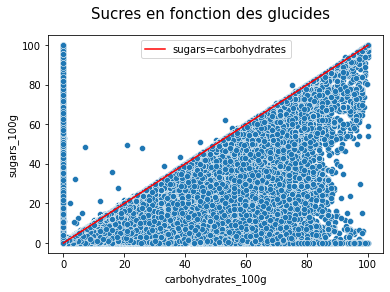

In [1327]:
ax = sns.scatterplot(y='sugars_100g', x='carbohydrates_100g', data=df)
x = np.linspace(0,100,3)
y = x
plt.plot(x, y, '-r', label='sugars=carbohydrates')
fig = plt.gcf()
# Ajout du titre
fig.suptitle("Sucres en fonction des glucides", fontsize=15);
plt.legend();

On observe qu'il y a des produits pour lesquels il y a plus de sucres que de glucides, ce qui est impossible. Il faut que toutes les valeurs soient en dessous de la droite. Il faut donc les traiter. 

In [1328]:
# On détermine la moyenne des rapports entre sucres et glucides pour les valeurs valides de glucide
dfsuc = df[(df['sugars_100g'] <= df['carbohydrates_100g']) & (df['carbohydrates_100g'] <= 100)]
coefsuc = 1/((dfsuc['sugars_100g']/dfsuc['carbohydrates_100g']).mean())

On procède de la même façon que pour la graisse et la graisse saturée. On remplace les valeurs erronées grâce au coefficient déterminé précedemment. 

In [1329]:
df.loc[(df['sugars_100g'] > df['carbohydrates_100g']) , "carbohydrates_100g"] = df["sugars_100g"]*coefsuc

df.loc[(df['carbohydrates_100g'] > 100) , "carbohydrates_100g"] = 100

### Traitement de la colonne energy_100g

On constate qu'il y a une corrélation plutôt forte entre l'énergie et la graisse. On peut donc envisager de calculer l'énergie à partir de la graisse. Regardons visuellement le rapport entre ces 2 valeurs nutritionnelles. 

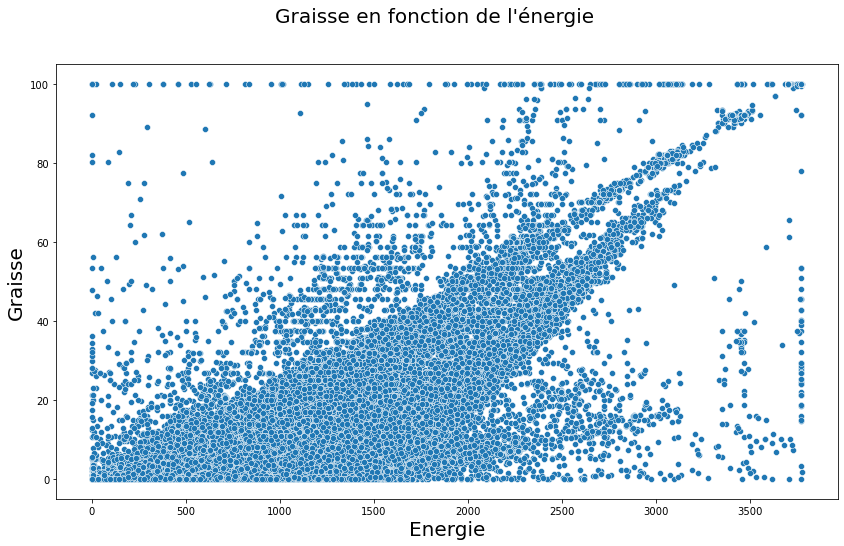

In [1330]:
ax = sns.scatterplot(x='energy_100g', y='fat_100g', data=df)

fig = plt.gcf()
# Ajout du titre
fig.suptitle("Graisse en fonction de l'énergie", fontsize=20);
# Modifie la taille du graphique
fig.set_size_inches(14,8)
# Ajout des labels pour les axes x et y
plt.xlabel("Energie", fontsize=20)
plt.ylabel("Graisse", fontsize=20, rotation=90);

On va regarder les ensembles des coefficients de corrélation pour voir de quelles valeurs on pourrait déduire l'énergie.

In [1331]:
dfcorr['energy_100g'].abs().sort_values(ascending=False)

energy_100g                             1.000000
fat_100g                                0.674078
nutrition-score-fr_100g                 0.589606
saturated-fat_100g                      0.573065
carbohydrates_100g                      0.406417
fruits-vegetables-nuts-estimate_100g    0.399612
sugars_100g                             0.311174
proteins_100g                           0.212911
ingredients_from_palm_oil_n             0.194975
fiber_100g                              0.172155
fruits-vegetables-nuts_100g             0.096656
vitamin-d_100g                          0.030540
salt_100g                               0.028036
sodium_100g                             0.028036
vitamin-c_100g                          0.012944
iron_100g                               0.007404
calcium_100g                            0.000508
Name: energy_100g, dtype: float64

On pourra effectuer une regression linéaire avec les colonnes sélectionnées qui me paraissent pertinentes.
On va garder 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'fiber_100g'.
On ne garde pas le nutriscore car on veut le déterminer à partir de l'énergie et non l'inverse, et il est lié aux valeurs citées précedemment. On ne garde pas les graisses saturées qui sont fortement corrélées aux graisses. De même pour le sucre qui est corrélé aux glucides.
On ne garde pas non plus les taux estimées de fruits et légumes ainsi que les ingrédients contenant de l'huilde de palme qui présentent une corrélation du fait de leur nombre très faible de valeurs renseignées. 

#### Mise en place de la régression linéaire

On va faire une regression linéaire en prenant comme échantillon les colonnes 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'fiber_100g', 'sugars_100g' pour lesquelles l'énergie est déterminé. 

In [1332]:
dfreg = df[df["energy_100g"].notna()]

# Données pour faire les expériences
X = dfreg[['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'fiber_100g']]
# Donnée à déterminer
y = dfreg['energy_100g']

# On entraine notre algorithme
reg = LinearRegression().fit(X, y)

On va regarder ce que donne notre modèle en l'appliquant à toutes les lignes dont on connait déjà les valeurs d'énergie et ne visualisant ces lignes. 

In [1333]:
energyreg = reg.predict(X)

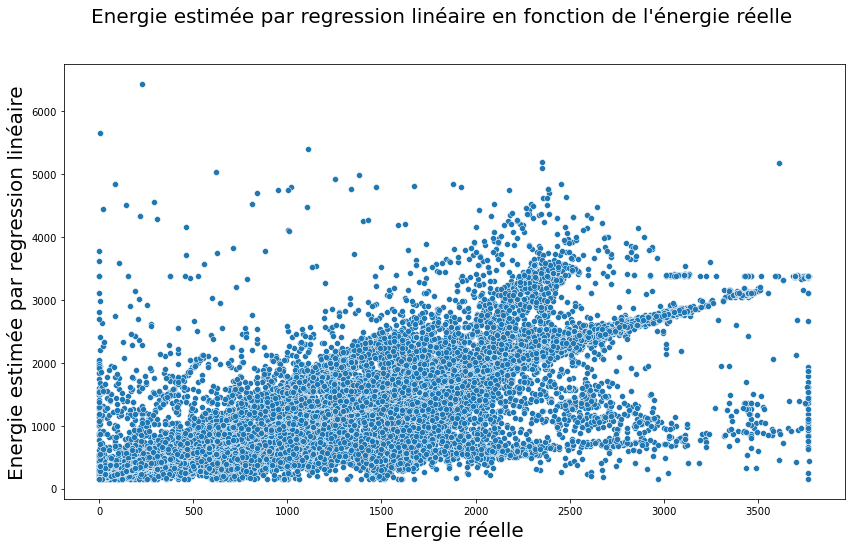

In [1334]:
ax = sns.scatterplot(x=dfreg['energy_100g'], y=energyreg)

fig = plt.gcf()
# Modifie la taille du graphique
fig.set_size_inches(14,8)
# Ajout du titre
fig.suptitle("Energie estimée par regression linéaire en fonction de l'énergie réelle", fontsize=20);
# Ajout des labels pour les axes x et y
plt.xlabel("Energie réelle", fontsize=20)
plt.ylabel("Energie estimée par regression linéaire", fontsize=20, rotation=90);

In [1335]:
# On regarde les coefficients
reg.coef_

array([32.19890867, 13.95704968, 16.79640572, 11.47323046])

In [1336]:
# On regarde la constante
reg.intercept_

151.3106463100446

On observe qu'on a bien une droite de pente 1 qui représente les valeurs pour lesquelles l'énergie obtenue via le modèle et l'énergie renseignée de base sont proches. On voit cependant que le modèle à ses limites car il y a beaucoup de valeurs dispersées. L'écart entre la valeur d'énergie réelle et estimée pour ces valeurs est grande.
On utilisera ce modèle pour complèter les valeurs d'énergies manquantes comme on en a peu à calculer, j'estime que ce sera satisfaisant. 

#### Comparaison avec la méthode calculatoire de la version précédente

On peut comparer avec la formule trouvée sur internet utilisée sur les versions précédentes. Elle utilise une formule semblable à la regression linéaire.  

In [1337]:
energycalc = dfreg.apply(
    lambda row: 37*row['fat_100g'] + 17*row['proteins_100g'] + 17*row['carbohydrates_100g'] + 8*row['fiber_100g'],
    axis=1)

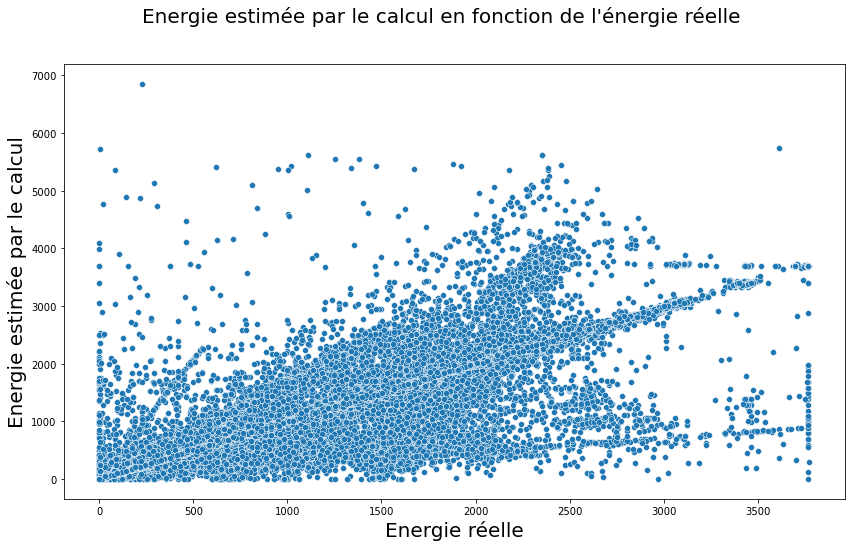

In [1338]:
ax = sns.scatterplot(x=dfreg['energy_100g'], y=energycalc)

fig = plt.gcf()
# Modifie la taille du graphique
fig.set_size_inches(14, 8)
# Ajout du titre
fig.suptitle("Energie estimée par le calcul en fonction de l'énergie réelle", fontsize=20);
# Ajout des labels pour les axes x et y
plt.xlabel("Energie réelle", fontsize=20)
plt.ylabel("Energie estimée par le calcul", fontsize=20, rotation=90);

On retrouve le même type de graphique que précédemment. C'est cohérent dans le sens où la formule utilisée est semblable, seuls les coefficients associés à chaque paramètre permettant d'effectuer le calcul varie. 

#### Remplacement des valeurs d'énergie manquantes

On va remplacer les valeurs d'énergie manquantes grâce à la prédiction du modèle de régression linéaire. Si la valeur prédite est supérieure à 3800, on capera cette valeur à 3800 pour ne pas avoir de valeurs aberrantes.

In [1339]:
# Remplacement des valeurs manquantes par à la régression linéaire
df["energy_100g"] = df.apply(
    lambda row: reg.predict(row[['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'fiber_100g']].to_frame().transpose())
    if np.isnan(row['energy_100g']) 
    else row['energy_100g'],
    axis = 1
)

In [1340]:
# Remplacement des valeurs prédites trop élevées par une valeur capée
df["energy_100g"] = df["energy_100g"].apply(
    lambda x: 3800
    if x > 3800 
    else x, 
)

On a donc maintenant l'ensemble de nos données pour calculer le nutriscore. 

### Visualisation de valeurs nutritionnelles

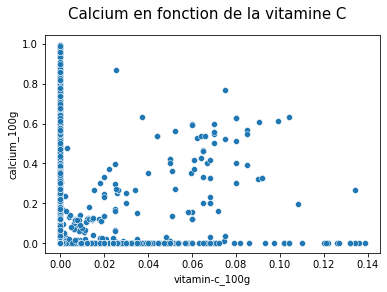

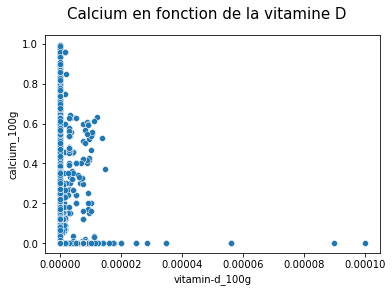

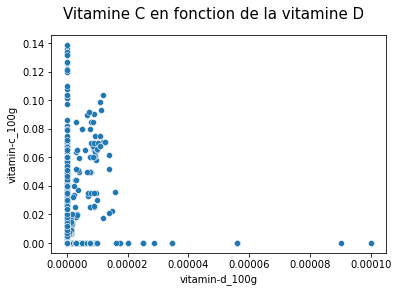

In [1341]:
plt.figure()
ax = sns.scatterplot(x='vitamin-c_100g', y="calcium_100g", data=df[(df['calcium_100g']<1) & (df['vitamin-c_100g']<0.15)])
fig = plt.gcf()
# Ajout du titre
fig.suptitle("Calcium en fonction de la vitamine C", fontsize=15)

plt.figure()
ax = sns.scatterplot(x='vitamin-d_100g', y="calcium_100g", data=df[df['calcium_100g']<1])
fig = plt.gcf()
# Ajout du titre
fig.suptitle("Calcium en fonction de la vitamine D", fontsize=15)

plt.figure()
ax = sns.scatterplot(x='vitamin-d_100g', y="vitamin-c_100g", data=df[(df['vitamin-d_100g']<0.0003) & (df['vitamin-c_100g']<0.15)])
fig = plt.gcf()
# Ajout du titre
fig.suptitle("Vitamine C en fonction de la vitamine D", fontsize=15);

J'ai du retirer quelques valeurs très élevées pour des compléments alimentaires qui avaient une teneur en nutriments très fortes pour rendre le graphe lisible. Avant de remplacer les valeurs manquantes par des zéros, le coefficient de corrélation entre les vitamines et le calcium était très élevé. Il y avait très peu de produits pour lesquels ces valeurs étaient simultanément renseignées, d'où le coefficient élevé. 

### Calcul du nutriscore 

On va calculer les nutriscores manquants. 

In [1342]:
# Mise en place des listes contenant les limites pour chaque valeur nutritionnelle
# Limites spécifiques aux solides
ptsNrjS=[335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350]
ptsSucS=[4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45]
ptsLegS=[40,60,80,80,80]

# Limites partagées entre solides et liquides
ptsSod=[0.090, 0.180, 0.270, 0.360, 0.450, 0.540, 0.630, 0.720, 0.810, 0.900]
ptsGra=[1, 2.1, 3.2, 4.3, 5.4, 6.5, 7.6, 8.7, 9.8, 10.9]
ptsFib=[0.9, 1.9, 2.8, 3.7, 4.7]
ptsPro=[1.6, 3.2, 4.8, 6.4, 8.0]

# Limites spécifiques aux liquides
ptsNrjL=[0, 30 , 60, 90, 120, 150, 180, 210, 240, 270]
ptsSucL=[0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5]
ptsLegL=[40, 40, 60, 80, 80, 80, 80, 80, 80, 80]

In [1343]:
def calcul_points(val, pts):
    """Donne le nombre de points de la valeur val par rapport à son placement relatif à la liste pts"""
    points=0
    # On parcourt parcourt la liste des limites jusqu'à trouver une limite majorant notre valeur nutritionnelle
    for points in range(len(pts)):
        if val <= pts[points]:
            return points
    return points+1


def nutriscore(catg, nrj, suc, gra, sel, leg, fib, pro):
    """Calcule le nutriscore à partir des valeurs nutritionnelles"""
    # Compteur de points positifs
    p=0
    # Compteur de points négatifs 
    n=0
    p = calcul_points(fib, ptsFib)
    n = n + calcul_points(gra, ptsGra) + calcul_points(sel/2.54, ptsSod)
    # Cas où le produit est un liquide
    if "beverage" in str(catg).lower():
        p = p + calcul_points(leg, ptsLegL)
        n = n + calcul_points(nrj, ptsNrjL) + calcul_points(suc, ptsSucL)
    # Cas où le produit est un solide
    else:
        p = p + calcul_points(leg, ptsLegS)
        n = n + calcul_points(nrj, ptsNrjS) + calcul_points(suc, ptsSucS)
    # Cas où les points des protéines ne sont pas pris en comptes
    if n >= 11 and leg < 100 and "fromage" not in str(catg).lower():
        return(n-p)
    # Cas où les points des protéines sont pris en compte
    p = p + calcul_points(pro, ptsPro)
    return (n-p)

In [1344]:
# On calcule les nutriscores qui ne sont pas renseignés
df["nutrition-score-fr_100g"] = df.apply(
    lambda row: nutriscore(row["pnns_groups_1"], row["energy_100g"], 
                           row["sugars_100g"], row["saturated-fat_100g"],
                           row["salt_100g"], row["fruits-vegetables-nuts_100g"], 
                           row["fiber_100g"], row["proteins_100g"]) 
    if np.isnan(row["nutrition-score-fr_100g"]) 
    else row["nutrition-score-fr_100g"], 
    axis=1)


### Calcul du nutrigrade

On va maintenant déduire les nutrigrades à partir des nutriscores en modifiant ceux déjà présents qui présentaient parfois des incohérences entre le nutriscore et le nutrigrade. 

In [1345]:
# Liste des valeurs de nutrigrade
grad=['a', 'b', 'c', 'd', 'e']
# Valeurs limites de nutriscore pour les solides
scoS=[-1, 2, 10, 19]
# Valeurs limites de nutriscore pour les liquides
scoL=[1, 5, 9]

In [1346]:
def nutrigrade(catg, nutriscore):
    """Calcule le nutrigrade à partir du nutriscore"""
    # Les critères ne sont pas les mêmes pour les liquides et les solides
    if "beverage" in str(catg).lower():
        # L'eau a toujours un nutrigrade de a
        if "eau" in str(catg).lower():
            return grad[0]
        return grad[calcul_points(nutriscore, scoL) + 1]
    return grad[calcul_points(nutriscore, scoS)]

In [1347]:
# On calcule le nutrigrade pour chaque valeur manquante
df["nutrition_grade_fr"] = df.apply(
    lambda row: nutrigrade(row["pnns_groups_1"], row["nutrition-score-fr_100g"]), 
    axis=1)

## Suppression des colonnes utilisées uniquement pour le nettoyage

Maintenant que le nettoyage est fini, on peut supprimer les colonnes pnns_groups_1 et generic_name qui étaient présentes uniquement pour remplir les valeurs manquantes d'autres colonnes. Elles ne seront plus utiles pour l'application. 

In [1348]:
# On garde uniquement les colonnes utiles pour l'application
df = df[['product_name', 'brands', 'countries_en', 'pnns_groups_1',
         'ingredients_text', 'allergens', 'traces', 'additives_en',
         'ingredients_from_palm_oil_n','nutrition_grade_fr', 'energy_100g',
         'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'salt_100g',
         'fat_100g', 'carbohydrates_100g',
         'proteins_100g', 'nutrition-score-fr_100g', 'fruits-vegetables-nuts_100g',
         'vitamin-d_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'image_url']]

df.shape

(92624, 25)

## Sauvegarde des données nettoyées

Maintenant que les données sont nettoyées, on peut les sauvegarder au format csv.

In [1349]:
df.to_csv("/home/apprenant/PycharmProjects/open-food-facts/data/openfoodfactsclean.csv")